In [2]:
from os import sys
sys.path.append("..")

# ODE Solver

The following code demonstrates how to solve first and second order ODE's using my software.

# First Order

To solve a first order ODE of the form $\frac{dx}{dt} = x$ it must first be written as a python funtion as follows:


In [1]:
import numpy as np

def f(x, t):
    """
    Returns an array with one element.

    Parameters
    ----------
    x : float
        The value of x.
    t : float
        The time the solution must be evaluated at.

    Returns
    -------
    x : the value of x.
    """
    return x


Now the ODE can be solved using custom ODE solver. Within this solver it is possible to specify a particular solving method from Euler's method, Runge-Kutta 4th order and Heun 3rd order. The initial condition x0 at time t=0 must also be specified, alongside the start and end times and the step-size the solver is to take. Finally, it should be specified whether it is a first or second order ODE: 'True' if it is a system of equations, otherwise 'False'. In this example, Euler's method will be used.

In [8]:
import math
import numpy as np
from ODE import solve_ode

# Set up the initial conditions
x0 = 1.0
t_eval = np.linspace(0, 5, 101) # time points to evaluate the solution
max_step = 0.01 # maximum step size for the solver
method = 'RK4' # numerical method for the solver
system = False # the ODE is not a system

# Solve the ODE using the solve_ode function
X = solve_ode(f, x0, t_eval, max_step, method, system)

To verify the numerical solution it can now be plotted against the true solution which is known to be:

$x(t)=e^t$

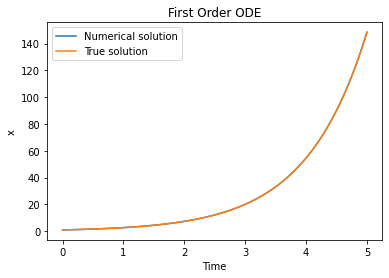

In [9]:
import matplotlib.pyplot as plt
def true_sol(t):
    """
    Returns the true solution of the first order ODE dx/dt = x.

    Parameters
    ----------
    t : numpy.ndarray
        An array containing the times the solution must be evaluated at.

    Returns
    -------
    numpy.ndarray
        An array containing the true solution of the first order ODE dx/dt = x.
    """
    return np.exp(t)

plt.plot(t_eval, X[:,0], label='Numerical solution')
plt.plot(t_eval, true_sol(t_eval), label='True solution')
plt.title('First Order ODE')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()


In [22]:
X = solve_ode(f, x0, t_eval, max_step, method, system)
tolerance = 1e-9 # set a tolerance value

# Compare the first 100 elements of X and true_sol(t_eval)
is_close = np.allclose(X[:,0], true_sol(t_eval), rtol=tolerance, atol=tolerance)
print(f"Numerical and exact solutions match closely: {is_close}")




Numerical and exact solutions match closely: True


# Higher Order ODEs

To solve higher order ODEs it is necessary to first convert the ODE into a system of first order ODEs. For example, the second order ODE $\ddot{x} = -x$, can be written as $\dot{x} = y$ and $\dot{y} = -x$. This is coded as a function to be passed to solve_ode as follows:

In [6]:
def f_ddot(X,t):
    x, y = X
    dxdt = y
    dydt = -x
    return np.array([dxdt, dydt])


This can now be passed to solve_ode. I will demonstrate the solution using Runge-Kutta 4th Order solver this time. It should be noted that the parameter distinguishing between system of ODEs is now set to 'True'.


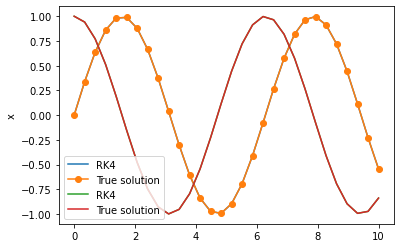

In [7]:


# Set up the initial conditions
x0 = [0, 1] # initial values of x and y
t_eval = np.linspace(0, 10, 30) # time points to evaluate the solution
max_step = 0.01 # maximum step size for the solver
method = 'RK4' # numerical method for the solver
system = True # the ODE is a system

# Solve the ODE using the solve_ode function
X = solve_ode(f_ddot, x0, t_eval, max_step, method, system)

def ddot_true_sol(t):
    x = np.sin(t)
    y = np.cos(t) 
    u = np.array([x, y])
    return u

######HIDE THIS CELL######
def plot_system_ode(X,t_eval,true_sol):
    true_sol = np.array([true_sol(t) for t in t_eval])

    plt.plot(t_eval, X[0], label='RK4')
    plt.plot(t_eval, true_sol[:,0], 'o-',label='True solution')
    plt.plot(t_eval, X[1], label='RK4')
    plt.plot(t_eval, true_sol[:,1], label='True solution')

    plt.ylabel('x')
    plt.legend()
    plt.show()

plot_system_ode(X,t_eval,ddot_true_sol)

# Error Evaluation and Code Testing

To Evaluate the performance of the three different Numerical solvers I have implemented, a function calculating the error between the numerical and analytical solutions at varying timesteps has been created. 


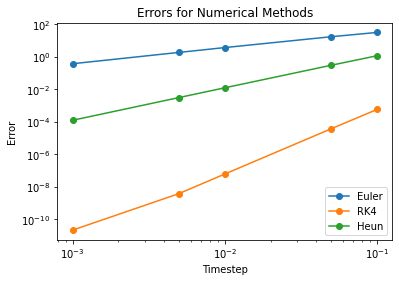

In [8]:
from plots import plot_error
from matplotlib import pyplot as plt
import numpy as np


def f(x, t):
    return x

# Define the true solution exp(t)
def true_sol(t):
    return np.exp(t)
x0 = 1  # initial condition
t0 = 0  # initial time
t1 = 5  # final time
dt_list = [0.1, 0.05, 0.01, 0.005, 0.001]  # list of timestep sizes to compare
args = ()  # empty tuple since there are no additional arguments for f
plot_error(f, true_sol, x0, t0, t1, dt_list, *args)

The above plot clearly demonstrates the superiority of the Runge-Kutta 4th order method, with the smallest error over a range of timesteps. 

# Numerical shooting

Please run the below code block initially.

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numdifftools as nd
from ODE import solve_ode

Before numerical_shooting is implemented, the predator-prey equations (Lokta-Voltera) are investigated. These take the form of: $\newline$
$\frac{dx}{dt} = x(1-x)-\frac{axy}{d+x}$

and

$\frac{dy}{dt}=by(1-\frac{y}{x})$

where a = 1, d = 0.1 and b = [0.1,0.5]

Below, the equations are plotted using a homemade plotting function. They first plot shows the differential equations for b<0.26. The second for b>0.26.

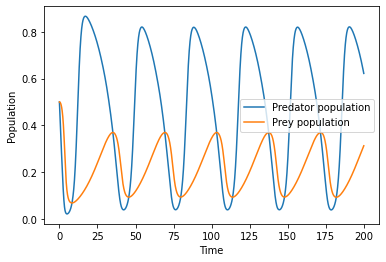

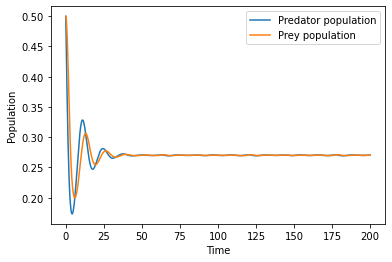

In [10]:
from shooting_plot import pred_prey_plot
def pred_prey_eq(X, pars):
  
    x = X[0]
    y = X[1]
    a, b, d = pars[0], pars[1], pars[2]
    dxdt = x * (1 - x) - (a * x * y) / (d + x)
    dydt = b * y * (1 - (y / x))
    return np.array([dxdt, dydt])


a = 1
d = 0.1
bs = [0.1,0.5]

pred_prey_plot(a,d,bs,pred_prey_eq)

As shown above for b<0.26 the solutions oscillate periodically and as b increases, x and y reach a stable equilibrium. 

I now implement a numerical shooting algorithm, which locates the initial conditions of the periodic orbit of the Predator-prey equations. For my shooting algorithm to work it is necessary to first define a phase condition. Ths phase condition has been determined to be $\frac{dx}{dt}(0)= 0$ from the course notes. I have parsed in the same arguments for the predator-prey equation as before, with b fixed as 0.1.

[ 0.81978612  0.16575823 34.06873819]


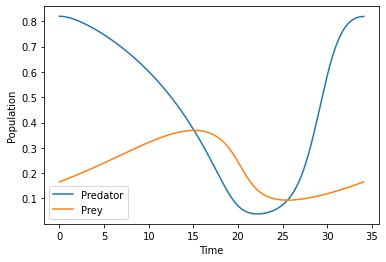

In [11]:
from shooting_plot import plot_solutions

def predator_prey(t, y, args = [1, 0.1, 0.1]):
    x = y[0]
    y = y[1]

    a = args[0]
    d = args[1]
    b = args[2]
     
    dxdt = x * (1 - x) - (a * x * y) / (d + x)
    dydt = b * y * (1 - (y / x))
    return np.array([dxdt, dydt])
    
def pc_predator_prey(u0, args = [1, 0.1, 0.1]):
    return predator_prey(0, u0, args = [1, 0.1, 0.1])[0]

# Define the initial guess for the shooting method
u0 = [0.8, 0.3,30]
plot_solutions(predator_prey,pc_predator_prey,u0,args=(), max_step=0.01)

The above code plots the isolated orbit found by the shooting algorithm.

I now test my shooting discretisation with the normal hopf bifurcation, to see if the initial conditions and period returned by my shooting function, provide accurate guesses to solve the system of differential equations. 

The normal hopf bifurcation is defined as: 

$\frac{du_1}{dt}=\beta u_1 - u_2 + \sigma u_1({u_1}^2+{u_2}^2) \newline$
$\frac{du_2}{dt}= u_1 - \beta u_2 + \sigma u_2({u_1}^2+{u_2}^2)$

with $\sigma = -1$ (supercritical Hopf) having explicit solutions:

$u_1(t)=\sqrt{\beta}cos(t+\theta)\newline$
$u_2(t)=\sqrt{\beta}sin(t+\theta)$

ImportError: cannot import name 'plot_hopf_shooting' from 'shooting_plot' (/Users/joesouber/Documents/scientific_computing/EMAT30008/shooting_plot.py)

# Numerical Continuation
Please run the following code block intially.

In [27]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import scipy
from scipy.integrate import solve_ivp
import math



In order to move beyond boundary-value problems and investigate parameter dependance, two methods of numerical continuation have been developed: Natural Parameter Continuation (NPC) and Pseudo-Arc-length continuation. 

They both have the ability to solve differential equations, by allowing the user to specify whether a discretisation is necessary. If it is, a generalised version of my numerical shooting function is implemented to find the first solution. This is then iterated through a set of parameters. 

Initially, the natrual parameter continuation is demonstrated on a standard cubic equation of the form: $x^3 - x +c$ and the bifurcation diagram is plotted. 

/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


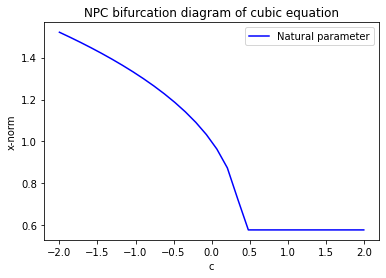

In [28]:
from numerical_continuation import npc

def cubic(x, pars):
    """
    This function defines a cubic equation
    :param x: Value of x
    :param pars: Defines the additional parameter c
    :return: returns the value of the cubic equation at x
    """
    c = pars[0]
    return x ** 3 - x + c

u0_guess_cubic = np.array([1])
np_par_list, np_sol_list = npc(cubic, u0_guess_cubic, [-2], 2, lambda x: x, fsolve,pc='none')
# Plot a graph of c against the norm of x (only one value in x so it is already the norm)
plt.plot(np_par_list, np_sol_list, 'b-', label='Natural parameter')

plt.title('NPC bifurcation diagram of cubic equation')
plt.xlabel('c'), plt.ylabel('x-norm'), plt.legend()
plt.show()

As demonstrated by the above bifurcation diagram, the NPC method fails at folds. It is, therefore, necessary to implement Pseudo-Arc-length continuation, by using the equation: $\delta\bar{u}\cdot(\bar{u}-\tilde{\bar{u}})+\delta p\cdot(p-\tilde{p})=0$



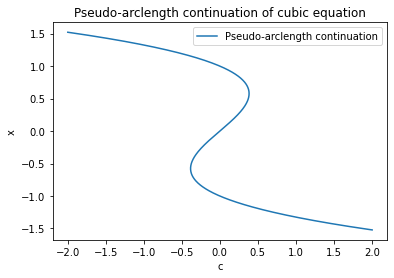

In [29]:
from numerical_continuation import pseudo_arclength

def cubic_eq(x, c):
    
    return x**3 -x +c

pseudo_par_list, pseudo_sol_list = pseudo_arclength(cubic_eq, 1, (-2, 2), 0.01, discretisation=lambda u0_, f, alpha: f(u0_, alpha))


    # Plot results - x against c
plt.plot(pseudo_par_list, pseudo_sol_list,label='Pseudo-arclength continuation')
plt.title('Pseudo-arclength continuation of cubic equation')
plt.legend()
plt.xlabel('c')
plt.ylabel('x')
plt.show()


This demonstrates the superirority of the Pseudo-arclength method, as it elegantly handles the folds in the cubic equation. 

As aforementioned, it is necessary to discretise differential equations in order to gain an initial solution guess for continuation to work. This is demonstrated below. Once again using the phase condition defined in shooting.

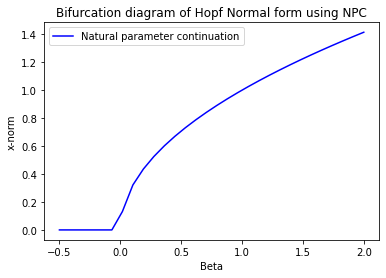

In [30]:
from shooting_plot import shooting_generalised

def normal_hopf(u0, t, pars):

    beta = pars[0]
    u1, u2 = u0[0], u0[1]

    du1dt = beta * u1 - u2 - (u1) * (u1 ** 2 + u2 ** 2)
    du2dt = u1 + beta * u2 - (u2) * (u1 ** 2 + u2 ** 2)
    return np.array([du1dt, du2dt])


# phase condition for the normal Hopf bifurcation (u1 gradient = 0)
def pc_normal_hopf(u0, pars):
    return normal_hopf(u0, 0, pars)[0]
u0_guess_hopfnormal = np.array([1.5, 0.1, 6.1])
np_par_list, np_sol_list = npc(normal_hopf, u0_guess_hopfnormal, [2], -0.5,shooting_generalised, fsolve,pc = pc_normal_hopf)


norm_np_sol_list = scipy.linalg.norm(np_sol_list[:, :-1], axis=1, keepdims=True)
plt.plot(np_par_list, norm_np_sol_list, 'b-', label='Natural parameter continuation')
plt.xlabel('Beta')
plt.ylabel('x-norm')
plt.legend()
plt.title('Bifurcation diagram of Hopf Normal form using NPC')
plt.show()


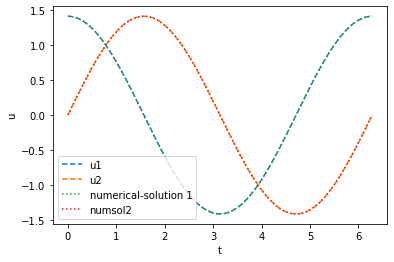

# PDE 

The overall aim of the PDE solvers I have built, is to use them to solve nonlinear diffusion equations of the form:

$\frac{du}{dt}= D\frac{{\delta^2}u}{{\delta}x^2}+q(x,t,u;\mu)$

Below I have various demonstrations, increasing in complexity. 


Below I show how to use my finite difference solver to solve numerically: $\frac{\delta u}{\delta t} = D\frac{{\delta^2}u}{\delta{x^2}}$, with the Dirichlet boundary conditions $u(a,t)=u(b,t)=0$ and the initial condition $u(x,0)=sin(\frac{\pi(x-a)}{b-a})$, where a =0

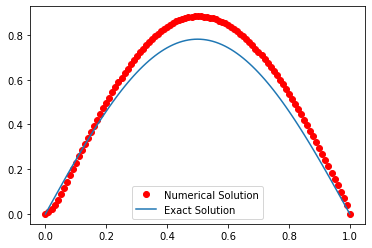

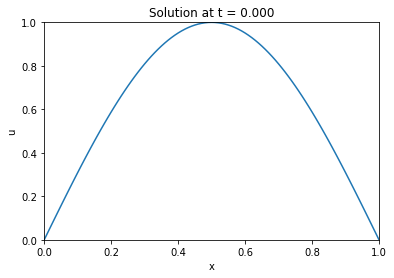

/Users/joesouber/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.sparse import diags, identity
from scipy.sparse.linalg import spsolve
from scipy.optimize import fsolve
from PDE import *
from plots import plot_comparison,animate_solution


L = 1   # domain length
T = 0.5    # final time
mx = 100    # steps in x
mt = 1000   # steps in t

def dirichlet_0(x,t):
    return 0

def Initial_Condition(x, L):
    y = (np.sin(np.pi*x/L))
    return y

# Call the pde solver function, using the Forward Euler method
u, t = finite_difference(L, T, mx, mt, 'dirichlet', dirichlet_0, Initial_Condition, discretisation='beuler',D = 0.1)

def exact_sol(x,t, D, L):
    '''
    The exact solution to the PDE defined above.
    '''
    y = np.exp(-D*(np.pi**2/L**2)*t)*np.sin(np.pi*x/L)
    return y

# Plot the solution
from plots import plot_comparison

D = 0.1
plot_comparison(u, t, L, D,exact_sol)

# Animates the solution, hwowever this is not working inside notebook. Works in a python file.
animate_solution(u, t, L)